In [1]:
%matplotlib inline
'''
How to Optimize Your Dragon: V5
Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import dill

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution,\
                                    trans_cnumber, trans_product_mole, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, tray_translator, check_iteration,\
                                    get_x_scale_factor# , check_violate_constraint
from utility.data_utility import cal_cnumber
from utility.time_utility import create_filename_time, log_now, log_end

2018-07-20 09:09:50 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'

In [3]:
with open('./log/model/stage_20_base_product.pickle','rb') as f:
    model = dill.load(f)

In [4]:
check_DOF(pe,model)

Active Equality Constraints:	 28997
Active Inequality Constraints:	 21
Active Variables:		 29462
Fixed Variables:		 392
DOF:				 73


# Add tray optimization related sets and variables

In [5]:
model.TRAY_total = pe.Set(initialize=['condenser']+[str(i) for i in model.TRAY]+['reboiler'],ordered=True)

In [6]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)

In [7]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [8]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)
        
for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))

In [9]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
    return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
            sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) * get_x_scale_factor(i) == (model.P_total[p])*model.x_P[i,p] * get_x_scale_factor(i)
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [10]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) * get_x_scale_factor(i) == model.x_P[i,p] * get_x_scale_factor(i)
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [11]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [12]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [13]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [14]:
for j in model.reactive:
    model.reactive[j].MPCC.rho = 10000
model.reboiler.MPCC.rho = 10000

In [15]:
check_DOF(pe,model)

Active Equality Constraints:	 29862
Active Inequality Constraints:	 21
Active Variables:		 30357
Fixed Variables:		 422
DOF:				 73


In [16]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['output_file'] = './tmp/ipopt_output_tmp.output'
opt.options['constr_mult_init_max '] = 1e8
opt.options['max_iter'] = 500

# opt.options['hessian_approximation'] = 'limited-memory'
opt.options['linear_solver'] = 'ma86'
opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'

opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20

opt.options['mu_init'] = 1e-6

In [17]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
output_file=./tmp/ipopt_output_tmp.output
constr_mult_init_max =100000000.0
max_iter=500
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                    constr_mult_init_max = 1e+08                 yes
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_pu

In [18]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-134.						3.0274	0.6481	0.0341		2.0654

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	119.8	0.000	0.0000	0.000	0.00	0.000		5.7751	0.7526	0.0000		20.000
NON--[2]	132.0	0.000	0.0000	0.000	0.00	0.000		5.8796	0.6828	0.0000		20.000
NON--[3]	141.4	0.000	0.0000	0.000	0.00	0.000		5.8098	0.6177	0.0023		20.000
NON--[4]	150.0	0.000	0.0000	0.000	0.00	0.000		5.7471	0.5326	0.0170		20.000
NON--[5]	158.7	0.000	0.0000	0.000	0.00	0.000		5.6790	0.4472	0.0023		20.000
NON--[6]	168.8	0.000	0.0000	0.000	0.00	0.000		5.5960	0.3336	0.0041		20.000
NON--[7]	182.3	0.000	0.0000	0.000	0.00	0.000		5.4865	0.1743	0.0305		20.000
React[8]	200.0	-24.1	0.1553	0.201	1.00	3000.		5.3577	0.

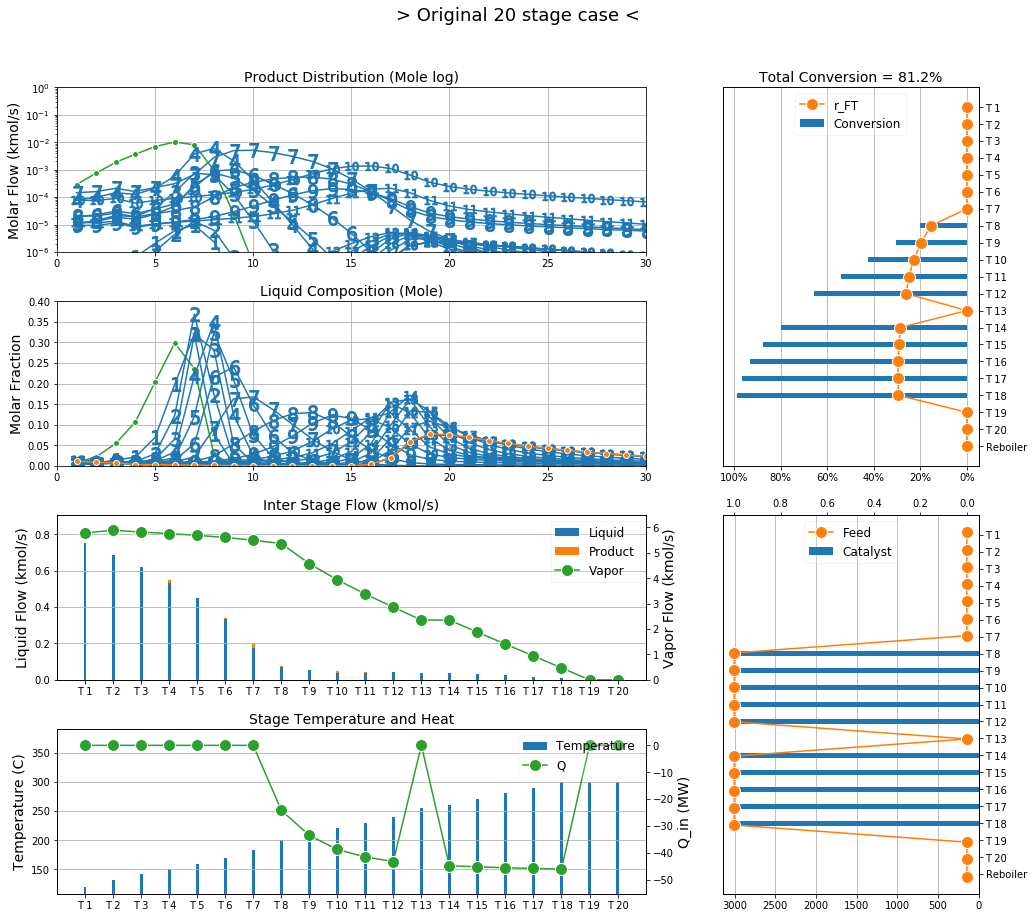

In [19]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Original 20 stage case')

# Optimization Input

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw ratio
    * PR_L: 0 - 1

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

### Open up parameters

In [20]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

In [21]:
model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [22]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

In [23]:
def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [24]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = model.P_total['gasoline'] - sum(model.reactive[j].MPCC.pf for j in model.reactive)\
                                - model.reboiler.MPCC.pf, sense = pe.maximize)

In [25]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
output_file=./tmp/ipopt_output_tmp.output
constr_mult_init_max =100000000.0
max_iter=500
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                    constr_mult_init_max = 1e+08                 yes
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_pu

  65 -1.0227073e-01 3.26e+01 3.87e+01  -6.0 1.53e+03    -  3.09e-02 6.46e-03h  2
  66 -1.0223742e-01 1.92e+01 8.07e+01  -6.0 6.80e+02    -  1.20e-02 1.00e+00H  1
  67 -1.0223518e-01 7.51e-03 1.81e-02  -6.0 3.62e+00  -7.6 1.00e+00 1.00e+00h  1
  68 -1.0223551e-01 1.58e-04 2.45e-04  -6.0 2.29e+00  -8.1 1.00e+00 1.00e+00h  1
  69 -1.0223594e-01 8.34e-04 9.61e-05  -6.0 6.89e+00  -8.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0223688e-01 2.30e-02 1.25e-03  -6.0 2.07e+01  -9.0 1.00e+00 1.00e+00h  1
  71 -1.0224034e-01 4.48e-01 1.18e-02  -6.0 6.21e+01  -9.5 1.00e+00 1.00e+00h  1
  72 -1.0225245e-01 5.40e+00 1.03e-01  -6.0 1.86e+02 -10.0 1.00e+00 1.00e+00h  1
  73 -1.0226151e-01 8.13e+00 6.95e+01  -6.0 8.62e+03    -  3.56e-01 1.54e-02h  2
  74 -1.0227087e-01 5.03e+00 2.89e+00  -6.0 1.88e+02    -  1.00e+00 7.12e-01h  1
  75 -1.0227098e-01 7.77e-03 2.76e-03  -6.0 1.57e+01    -  1.00e+00 1.00e+00h  1
  76 -1.0227096e-01 7.77e-06


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-162.						2.1386	0.9921	0.0871		2.3285

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	133.7	0.000	0.0000	0.000	0.00	0.000		5.5466	1.2312	0.0000		20.000
NON--[2]	149.7	0.000	0.0000	0.000	0.00	0.000		5.7857	1.1758	0.0000		20.000
NON--[3]	160.9	0.000	0.0000	0.000	0.00	0.000		5.7303	1.1268	0.0000		20.000
NON--[4]	170.0	0.000	0.0000	0.000	0.00	0.000		5.6813	1.0611	0.0000		20.000
NON--[5]	178.7	0.000	0.0000	0.000	0.00	0.000		5.6156	0.9577	0.0000		20.000
NON--[6]	189.4	0.000	0.0000	0.000	0.00	0.000		5.5123	0.7738	0.0109		20.000
NON--[7]	205.9	0.000	0.0000	0.000	0.00	0.000		5.3393	0.4561	0.0803		20.000
React[8]	230.6	-31.6	0.258

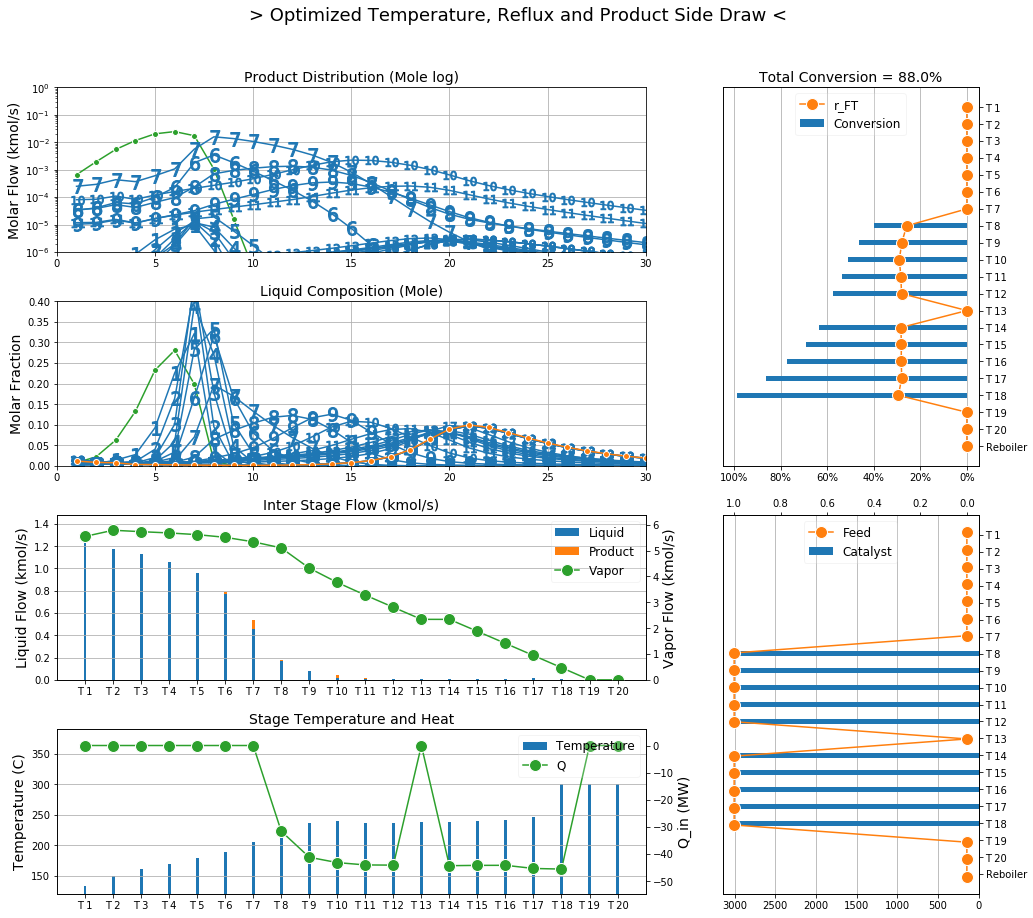

In [26]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Side Draw')

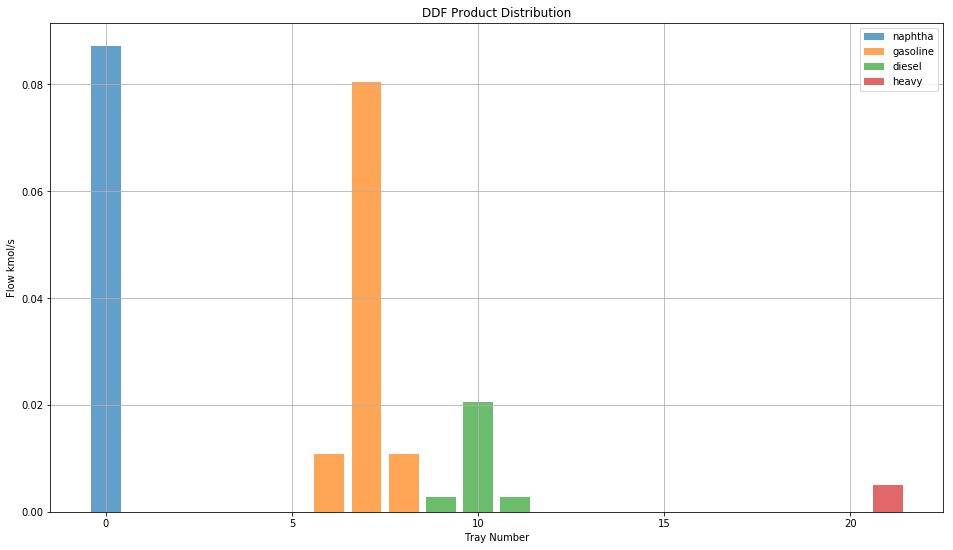

In [27]:
tray_num = len(model.TRAY_total)
tray_pos = np.arange(tray_num)

naphtha_flow = [model.P_tray[j,'naphtha'].value for j in model.TRAY_total]
gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]
heavy_flow = [model.P_tray[j,'heavy'].value for j in model.TRAY_total]

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(tray_pos,naphtha_flow,alpha=0.7)
ax.bar(tray_pos,gasoline_flow,alpha=0.7)
ax.bar(tray_pos,diesel_flow,alpha=0.7)
ax.bar(tray_pos,heavy_flow,alpha=0.7)

ax.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('DDF Product Distribution')
ax.set_ylabel('Flow kmol/s')
ax.set_xlabel('Tray Number')

ax.grid()
plt.show()

# Use DDF,  open up gasoline location

In [28]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [29]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
output_file=./tmp/ipopt_output_tmp.output
constr_mult_init_max =100000000.0
max_iter=500
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                    constr_mult_init_max = 1e+08                 yes
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_pu


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-151.						2.1363	0.7792	0.0812		2.3197

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	127.5	0.000	0.0000	0.000	0.00	0.000		5.3165	0.9217	0.0000		20.000
NON--[2]	141.2	0.000	0.0000	0.000	0.00	0.000		5.4590	0.8360	0.0000		20.000
NON--[3]	152.9	0.000	0.0000	0.000	0.00	0.000		5.3734	0.7452	0.0000		20.000
NON--[4]	165.4	0.000	0.0000	0.000	0.00	0.000		5.2826	0.6025	0.0084		20.000
NON--[5]	181.6	0.000	0.0000	0.000	0.00	0.000		5.1484	0.3499	0.0832		20.000
NON--[6]	202.7	0.000	0.0000	0.000	0.00	0.000		4.9789	0.2260	0.0151		20.000
NON--[7]	218.7	0.000	0.0000	0.000	0.00	0.000		4.8702	0.1695	0.0000		20.000
React[8]	228.2	-40.8	0.2564	0.386	1.00	3000.		4.81

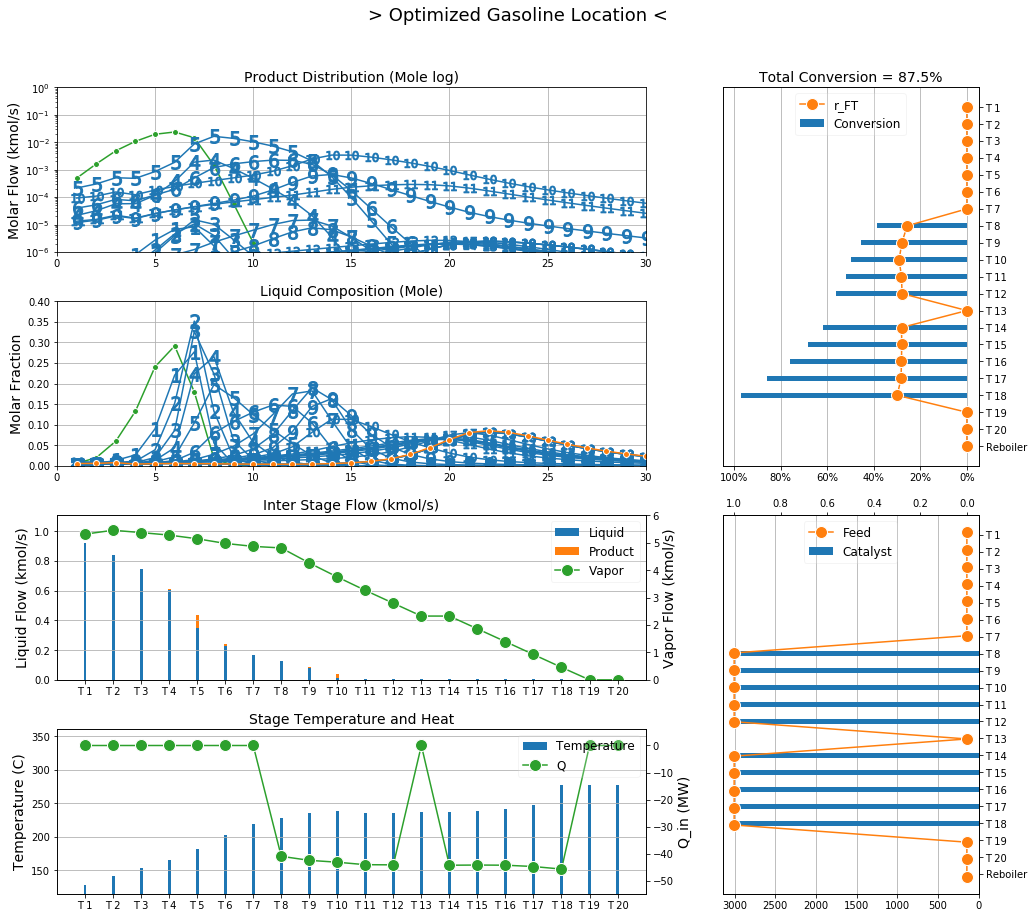

In [30]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Gasoline Location')

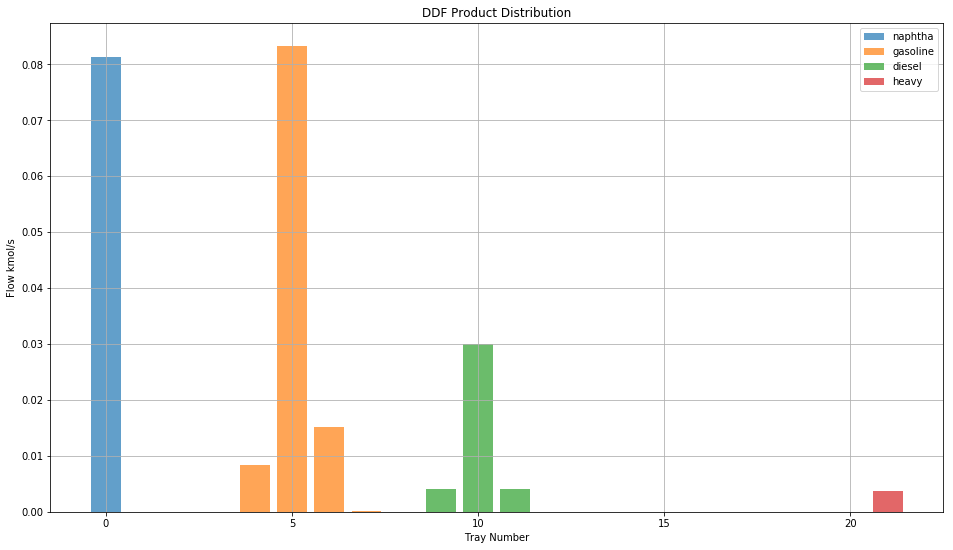

In [31]:
tray_num = len(model.TRAY_total)
tray_pos = np.arange(tray_num)

naphtha_flow = [model.P_tray[j,'naphtha'].value for j in model.TRAY_total]
gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]
heavy_flow = [model.P_tray[j,'heavy'].value for j in model.TRAY_total]

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(tray_pos,naphtha_flow,alpha=0.7)
ax.bar(tray_pos,gasoline_flow,alpha=0.7)
ax.bar(tray_pos,diesel_flow,alpha=0.7)
ax.bar(tray_pos,heavy_flow,alpha=0.7)

ax.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('DDF Product Distribution')
ax.set_ylabel('Flow kmol/s')
ax.set_xlabel('Tray Number')

ax.grid()
plt.show()

In [32]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(5)
model.N_tray['diesel'].setub(20)

In [33]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
output_file=./tmp/ipopt_output_tmp.output
constr_mult_init_max =100000000.0
max_iter=500
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                    constr_mult_init_max = 1e+08                 yes
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
                   warm_start_bound_pu

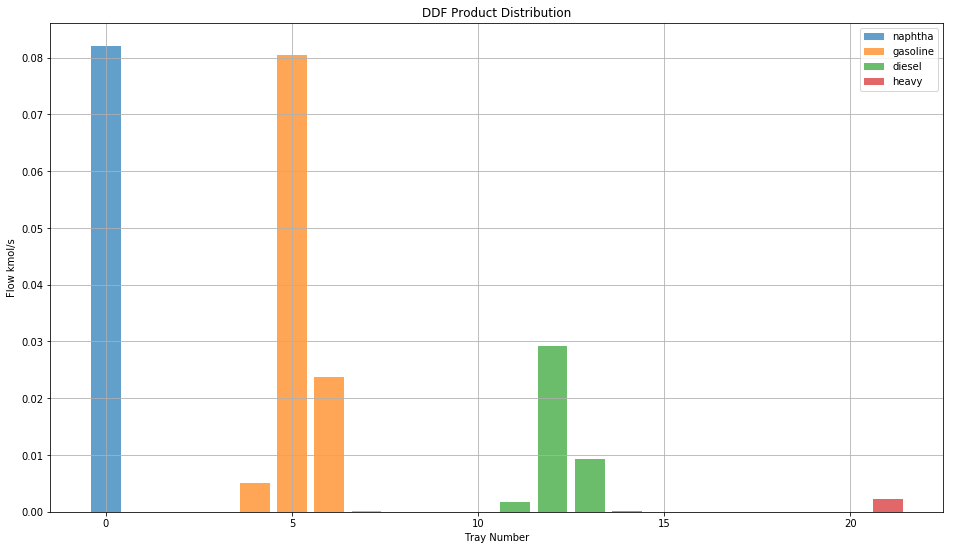

In [34]:
tray_num = len(model.TRAY_total)
tray_pos = np.arange(tray_num)

naphtha_flow = [model.P_tray[j,'naphtha'].value for j in model.TRAY_total]
gasoline_flow = [model.P_tray[j,'gasoline'].value for j in model.TRAY_total]
diesel_flow = [model.P_tray[j,'diesel'].value for j in model.TRAY_total]
heavy_flow = [model.P_tray[j,'heavy'].value for j in model.TRAY_total]

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(tray_pos,naphtha_flow,alpha=0.7)
ax.bar(tray_pos,gasoline_flow,alpha=0.7)
ax.bar(tray_pos,diesel_flow,alpha=0.7)
ax.bar(tray_pos,heavy_flow,alpha=0.7)

ax.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('DDF Product Distribution')
ax.set_ylabel('Flow kmol/s')
ax.set_xlabel('Tray Number')

ax.grid()
plt.show()


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_Prod	L_out	L_Prod		W
Condenser	30.00	-154.						2.0987	0.8402	0.0820		2.3344

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	128.5	0.000	0.0000	0.000	0.00	0.000		5.3555	1.0040	0.0000		20.000
NON--[2]	142.5	0.000	0.0000	0.000	0.00	0.000		5.5193	0.9182	0.0000		20.000
NON--[3]	154.4	0.000	0.0000	0.000	0.00	0.000		5.4335	0.8276	0.0000		20.000
NON--[4]	166.8	0.000	0.0000	0.000	0.00	0.000		5.3429	0.6876	0.0050		20.000
NON--[5]	182.7	0.000	0.0000	0.000	0.00	0.000		5.2080	0.4327	0.0804		20.000
NON--[6]	203.4	0.000	0.0000	0.000	0.00	0.000		5.0336	0.2899	0.0237		20.000
NON--[7]	220.2	0.000	0.0000	0.000	0.00	0.000		4.9146	0.2310	0.0001		20.000
React[8]	230.0	-41.0	0.2615	0.396	1.00	3000.		4.8558

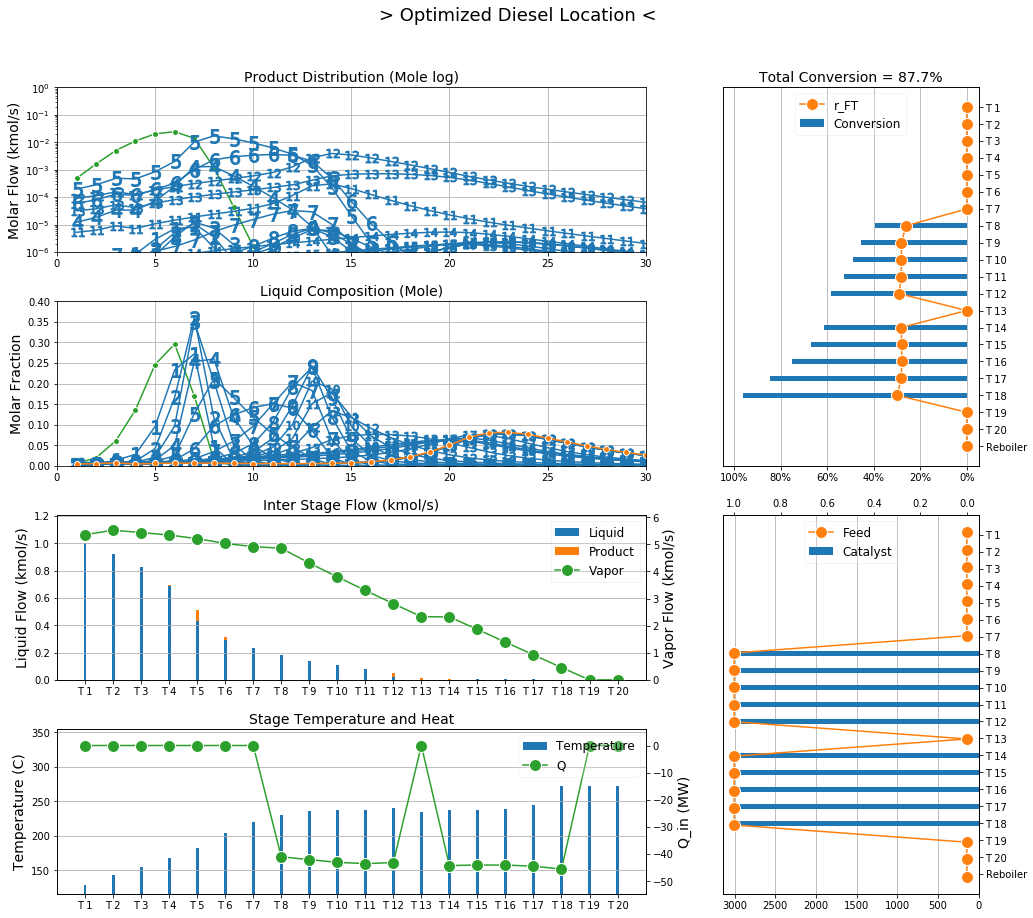

In [35]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()

plot_distribution(model,pdf,'Optimized Diesel Location')

# Open up feed allocation

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [36]:
# for j in model.reactive:
#     model.reactive[j].F.unfix()
#     model.reactive[j].F.setlb(0)
#     model.reactive[j].F.setub(10)

In [37]:
# model.total_feed_con = pe.ConstraintList()

In [38]:
# model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [39]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [40]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Feed Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Feed Amount and Location')

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3
        
* Catalyst
    * cat: 0 - 10000

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75 / 0.8
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * sum feed = 10 kmol/s
    
* Total catalyst
    * sum cat = 30000 kg
    
**Objective:**
* Max gasoline production

In [41]:
# for j in model.reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(0)
#     model.reactive[j].cat.setub(30000)

In [42]:
# model.total_cat_con = pe.ConstraintList()

In [43]:
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [44]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [45]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')

In [46]:
pdf.close()

In [47]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)

In [48]:
# for j in model.TRAY_reactive:
#     print('stage',j,'\n')
#     print('Total Flow\t{}'.format(model.reactive[j].F.value + sum(model.reactive[j].r_total_comp[i].value for i in m.COMP_TOTAL)))
#     for i in m.COMP_TOTAL:
#         if i in m.COMP_FEED:
#             print('{}\t\t{}'.format(i,model.reactive[j].F.value*model.reactive[j].z[i].value + model.reactive[j].r_total_comp[i].value))
#         else:
#             print('{}\t\t{}'.format(i,model.reactive[j].r_total_comp[i].value))